In [8]:
import datetime
import os
import cv2
import numpy as np
import pandas as pd
from facenet_pytorch import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model

In [44]:
# Create a folder with the current date and time for debugging purposes
folder_name = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
folder_path = os.path.join(os.getcwd(), "faces_export", folder_name)
os.makedirs(folder_path, exist_ok=True)

# Initialize Objects
face_detector = MTCNN(keep_all=True, post_process=False, margin=20)
video = cv2.VideoCapture("/Users/ben/neuefische/capstone/ai-with-python-series/07. Emotion Recognition using Live Video/content/Baseball Training.mp4")

# Initialize Emotion Detection Model
emotion_classifier = load_model("../models/emotion_model.hdf5", compile=False)
emotion_classifier.make_predict_function()
input_face_size = emotion_classifier.input_shape[1:3]

# For now: use list
list_of_images = []
list_of_faces_coloured = []
list_of_faces_grey_scaled = []
list_for_frame_axis = []
frames_without_faces_counter = 0
max_number_of_faces_in_frame = 0

skip_frames = 1
frame_count = 0
while True:

    # Read the next frame from the video
    ret, frame = video.read()

    # Check if the frame was successfully read
    if not ret:
        break

    # Increment the frame count and skip frames if necessary
    frame_count += 1
    if frame_count % skip_frames != 0:
        continue

    # Leads to much better results in face detection - maybe later compare quantitatively
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # for now:
    list_of_images.append(frame)

    faces = face_detector(frame)

    # Check if any faces were found
    if faces is None:
        frames_without_faces_counter += 1
        continue

    amount_of_faces = faces.size(0)

    if amount_of_faces > max_number_of_faces_in_frame:
        max_number_of_faces_in_frame = amount_of_faces

    for i in range(amount_of_faces):
        # Extract the i-th image from the tensor
        face = faces[i]

        # Append framecount to tracking list
        list_for_frame_axis.append((frame_count,i+1))

        # Save the extracted face as a PNG file in the folder
        face_filename = f"face_{frame_count}_{i}.png"
        face_filepath = os.path.join(folder_path, face_filename)
        cv2.imwrite(face_filepath, cv2.cvtColor(face.permute(1, 2, 0).numpy(), cv2.COLOR_RGB2BGR))

        # for now:
        list_of_faces_coloured.append(face)

        grey_face = cv2.cvtColor(face.permute(1, 2, 0).numpy(), cv2.COLOR_BGR2GRAY)

        try:
            grey_face = cv2.resize(grey_face, input_face_size)
        except Exception as e:
            print("{} resize failed: {}".format(grey_face.shape, e))
            continue

        list_of_faces_grey_scaled.append(grey_face)       

# Release the video and close the window
video.release()

print(f'{len(list_of_images)} images put into list_of_images')
print(f'{len(list_of_faces_coloured)} faces found and put into list_of_faces')
print(f'In {frames_without_faces_counter} frames there was no face found ({round(100*frames_without_faces_counter/len(list_of_images),2)}%).')
print(f'Maximum number of faces found in one frame: {max_number_of_faces_in_frame}.')

emotions = emotion_classifier(np.array(list_of_faces_grey_scaled))

519 images put into list_of_images
358 faces found and put into list_of_faces
In 187 frames there was no face found (36.03%).
Maximum number of faces found in one frame: 2.


In [45]:
df_emotions = pd.DataFrame(emotions.numpy())
df_frames_and_face_nrs = pd.DataFrame(list_for_frame_axis, columns=['frame', 'face_nr_in_frame'])
df_emotions = pd.concat([df_emotions, df_frames_and_face_nrs], axis=1)
df_plotting = pd.melt(df_emotions, id_vars=['frame', 'face_nr_in_frame'], value_vars=[0,1,2,3,4,5,6], var_name='feeling', value_name='probability')

In [46]:
df_emotions.head(30)

,0,1,2,3,4,5,6,frame,face_nr_in_frame
0,1.000000,0.0,2.202091e-31,0.0,0.0,0.0,0.0,1,1
1,1.000000,0.0,1.289123e-31,0.0,0.0,0.0,0.0,2,1
2,1.000000,0.0,0.000000e+00,0.0,0.0,0.0,0.0,3,1
3,1.000000,0.0,1.077511e-30,0.0,0.0,0.0,0.0,4,1
4,1.000000,0.0,9.930757e-13,0.0,0.0,0.0,0.0,5,1
5,1.000000,0.0,0.000000e+00,0.0,0.0,0.0,0.0,6,1
6,1.000000,0.0,0.000000e+00,0.0,0.0,0.0,0.0,7,1
7,1.000000,0.0,0.000000e+00,0.0,0.0,0.0,0.0,8,1
8,1.000000,0.0,5.471524e-33,0.0,0.0,0.0,0.0,9,1
9,1.000000,0.0,0.000000e+00,0.0,0.0,0.0,0.0,10,1


In [58]:
df_plotting.sort_values(by = ['frame','face_nr_in_frame', 'feeling']).head(50)

,frame,face_nr_in_frame,feeling,probability
0,1,1,0,1.000000e+00
358,1,1,1,0.000000e+00
716,1,1,2,2.202091e-31
1074,1,1,3,0.000000e+00
1432,1,1,4,0.000000e+00
1790,1,1,5,0.000000e+00
2148,1,1,6,0.000000e+00
1,2,1,0,1.000000e+00
359,2,1,1,0.000000e+00
717,2,1,2,1.289123e-31


In [50]:
!pip install seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)


In [51]:
import seaborn as sns

<Axes: xlabel='frame', ylabel='probability'>

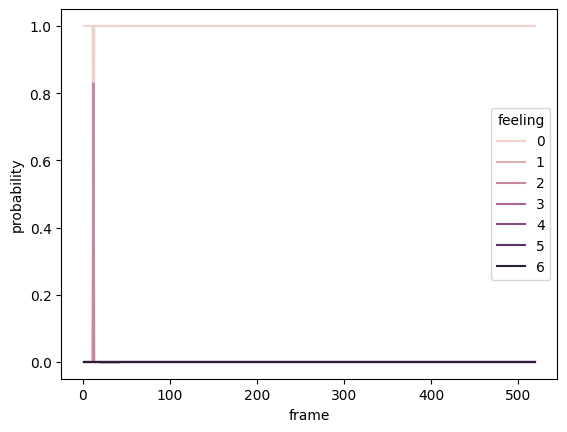

In [59]:
sns.lineplot(data = df_plotting, x = 'frame', y='probability', hue = 'feeling')

In [ ]:
emotion_categories= {
            0: "angry",
            1: "disgust",
            2: "fear",
            3: "happy",
            4: "sad",
            5: "surprise",
            6: "neutral",
        }

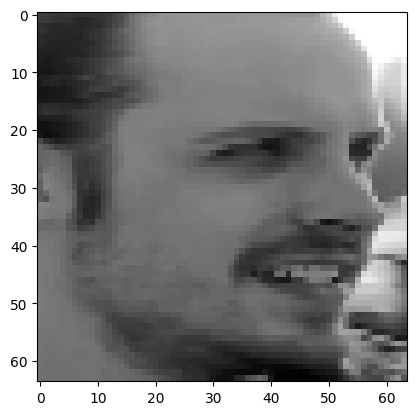

In [22]:
# Display the first image in the results list
plt.imshow(results[66], cmap='gray')
plt.show()

Old / not yet used

In [19]:

    
    # Loop through each detected face and perform emotion detection
    for (x, y, w, h) in faces:
        face_img = frame[y:y+h, x:x+w]
        emotion_preds = DeepFace.analyze(face_img, actions=["emotion"])
        emotion_dict = emotion_preds["emotion"]

        #labels for plotting on video
        emotion_label = max(emotion_preds["emotion"].items(), key=lambda x: x[1])  # get the label with the highest probability
        cv2.putText(frame, emotion_label[0], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # Add the timestamp and emotion probabilities to the dataframe
        timestamp = frame_count / video.get(cv2.CAP_PROP_FPS)
        row = {'timestamp': timestamp, 'emotion': emotion_dict}
        df = df.append(row, ignore_index=True)
        
        # Draw a rectangle around the face and display the dominant emotion
        emotion_label = max(emotion_dict.items(), key=lambda x: x[1])[0]
        cv2.putText(frame, emotion_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    # Show the frame with the detected faces and emotions
    cv2.imshow("Emotion Detection", frame)
    if cv2.waitKey(1) == ord("q"):
        break

# Release the video and close the window
video.release()
cv2.destroyAllWindows()

# Print the dataframe
print(df)

ValueError: Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.